# Playback



In [10]:
from maelzel.core import *
from pitchtools import *

## Presets

**maelzel** uses **csound** for audio synthesis in realtime and offline. Each event uses an instrument preset to synthesize the notes parameters (pitch, amplitude, etc.) and generate audio. Within an instrument preset three variables are exposed: `kfreq` (the current frequency of the event), ``kamp`` (the current amplitude of the event) and `kpitch` (the current midinote of the event, corresponds to `kfreq`). With this information the user needs to provide the audio-generating part using csound code, by assigning the audio output to the variable `aout1` for channel 1, `aout2` for channel 2, etc.

There are a number of built-in Presets and it is very easy to **define new presets**. A new Preset is defined via `defPreset` or `defPresetSoundfont` (which uses a soundfont to generate the audio for each event).

All events share a set of standardized parameters:

* `delay`: an extra delay added to the absolute offset of the event
* `chan`: the first channel to send output to. A stereo preset will send its output to `chan` and `chan+1`. As in csound, channels start with 1
* `gain`: a gain factor to modify the amplitude of the event
* `fade`: a value or a tuple (fade in, fade out), applies a declicking envelope to the sound
* `instr`: the name of the preset to use
* `pitchinterpol`: the interpolation used for pitches (one of `linear`, `cos`, 'freqlinear')
* `fadeshape`: the shape of the event envelope, one of `linear`, `cos`
* `priority`: sets the evaluation order. An event with lower priority is evaluated first, an event with a higher priority is evaluated later. A reverb should have a higher  priority than the events sending their output to this reverb
* `position`: panning position. 0: left, 1: right
* `sustain`: extra duration of the event
* `transpose`: a transposition applied for playback only
* `skip`: skip a given amount of time (in seconds) from playback
* `end`: stop playback at the given time
* `glisstime`: for glissando events, sets the actual time of the glissando itself. This is useful for legato playback in monphonic instruments
* `args`: arguments passed to the preset itself

## Complex Instruments

**maelzel** can be used for pure synthesis. 

In the following example there is an implementation of **Chownings' stria** instrument. This simple instrument uses FM together with a set of envelope tables to generate a variety of organic and complex sounds. The output of each note is routed to a post-processing instrument, which implements reverb and a set of lowpass filters to model high-frequency absortion. 

Since the sound of each note of the 'stria' instrument is not output directly but routed via the reverb instrument, the preset definition is created with `output=False`. This preset defines a set of envelope tables (also copied verbatim from the original implementation) which are created once and shared by all notes. In general, when using csound within maelzel or csoundengine it is recommended to avoid assigning hard-coded table numbers (or instrument numbers). For that reason the table numbers are left unspecified and kept in a global array `gi__tables`. Then the user can refer to the tables by this ad-hoc index.

In [2]:
defPreset("stria", r'''
| ifreqmodA=1000, ifreqmodB=1000, indxa1=1, indxa2=1, indxb1=1, indxb2=1, ifn1=2, ifn2=6, ifn3=2, ifn4=4, ireverb=0.1, iatt=0.1, idec=0.1, ienvfactor=4, idistance=0.33, ichn1=0.5, ichn2=0.5, ichn3=0.5, ichn4=0.5|
  ; Stria FM instrument
  
  ; Original pfields
  ;  1    2    3    4     5    6     7      8      9    10 
  ;                 iamp  ifc  ifma  indxa1 indxa2 ifmb indxb1 
  ;indxb2 att  dec  %skew dis  %rev  0      0      0    0
  ;  0    ch1  ch2  ch3   ch4  0     0      ifn1   ifn2  ifn3 
  
  ifn1 = gi__tables[ifn1 - 1]
  ifn2 = gi__tables[ifn2 - 1]
  ifn3 = gi__tables[ifn3 - 1]
  ifn4 = gi__tables[ifn4 - 1]

  idifa = indxa2 - indxa1
  idifb = indxb2 - indxb1                 
  imag = 1                       ; fun to test
  ifactor = (p3-(iatt+idec))/2

  ;  generate global envelop pointer
  kndx linseg 0, iatt, 0.25, ifactor, 0.5, ifactor, 0.75, idec, 1
  
  ; generate first envelop (env)
  kenv = table:k(kndx, ifn1, 1) * kamp
  
  ; generate second envelop (skew)
  kskew = 1 + table:k(kndx, ifn2, 1) * ienvfactor
  
  ; generate third envelop (fda)
  kfda = table:k(kndx, ifn3, 1) * (ifreqmodA * idifa * imag)
  
  ; generate fourth envelop(fdb)
  kfdb = table:k(kndx, ifn4, 1) * (ifreqmodB * idifb * imag)

  amoda     oscil       (ifreqmodA*indxa1*imag)+kfda, (ifreqmodA*imag)*kskew
  amodb     oscil       (ifreqmodA*indxb1*imag)+kfdb, (ifreqmodB*imag)*kskew
  aphase = ((kfreq*imag)*kskew)+amoda+amodb
  asig      oscil       kenv, aphase

  ga__reverb += (asig*ireverb)   ; sends reverb signal
  asig *= idistance              ; adjust distance

  aout1 = asig * ichn1 + asig * ichn3
  aout2 = asig * ichn2 + asig * ichn4

  ga__channel1 += aout1          ; send to master buses
  ga__channel2 += aout2
''', init=r'''
i_ft0 ftgenonce 0, 0, 16385, 10, 1
i_ft1 ftgenonce 0, 0, 16385, 7, 0, 4096, 0.33, 4096, 1, 4096, 0.33, 4096, 0
i_ft2 ftgenonce 0, 0, 16385, 7, 1, 2094, 0.543, 3152, 0.367, 7383, 0.2037, 1284, 0.0845, 2471, 0
i_ft3 ftgenonce 0, 0, 16385, 27, 0, 1, 1500, 0.4, 2500, 0.2, 3220, 0.15, 4220, 0.08, 5464, 0, 16384, 0
i_ft4 ftgenonce 0, 0, 16385, 7, 0.6904, 2525, 1, 3465, 0.71, 4004, 0.255, 1351, 0.15, 5039, 0
i_ft5 ftgenonce 0, 0, 16385, 7, -0.5, 3276, 0.04, 3276, 0.08, 3276, 0.01, 6552, 0.03
i_ft6 ftgenonce 0, 0, 16385, 27, 0, 0, 3000, 0.35, 3010, 0.85, 3100, 1, 6034, 0.857, 7415, 0.44, 8967, 0.214, 11296, 0.107, 16384, 0
i_ft7 ftgenonce 0, 0, 16385, 27, 0, 0, 2071, 0.135, 3279, 0.270, 3712, 0.416, 3889, 0.827, 4580, 0.949, 5270, 0.998, 6478, 1, 7253, 0.916, 8113, 0.7, 10093, 0.365, 11557, 0.234, 16384, 0
i_ft8 ftgenonce 0, 0, 16385, 7, 0, 16385, 1
gi__tables[] array i_ft0, i_ft1, i_ft2, i_ft3, i_ft4, i_ft5, i_ft6, i_ft7, i_ft8

''', output=False)

Preset: stria  
    routing=False
  init: i_ft0 ftgenonce 0, 0, 16385, 10, 1
i_ft1 ftgenonce 0, 0, 16385, 7, 0, 4096, 0.33, 4096, 1, 4096, 0.33, 4096, 0
i_ft2 ftgenonce 0, 0, 16385, 7, 1, 2094, 0.543, 3152, 0.367, 7383, 0.2037, 1284, 0.0845, 2471, 0
i_ft3 ftgenonce 0, 0, 16385, 27, 0, 1, 1500, 0.4, 2500, 0.2, 3220, 0.15, 4220, 0.08, 5464, 0, 16384, 0
i_ft4 ftgenonce 0, 0, 16385, 7, 0.6904, 2525, 1, 3465, 0.71, 4004, 0.255, 1351, 0.15, 5039, 0
i_ft5 ftgenonce 0, 0, 16385, 7, -0.5, 3276, 0.04, 3276, 0.08, 3276, 0.01, 6552, 0.03
i_ft6 ftgenonce 0, 0, 16385, 27, 0, 0, 3000, 0.35, 3010, 0.85, 3100, 1, 6034, 0.857, 7415, 0.44, 8967, 0.214, 11296, 0.107, 16384, 0
i_ft7 ftgenonce 0, 0, 16385, 27, 0, 0, 2071, 0.135, 3279, 0.270, 3712, 0.416, 3889, 0.827, 4580, 0.949, 5270, 0.998, 6478, 1, 7253, 0.916, 8113, 0.7, 10093, 0.365, 11557, 0.234, 16384, 0
i_ft8 ftgenonce 0, 0, 16385, 7, 0, 16385, 1
gi__tables[] array i_ft0, i_ft1, i_ft2, i_ft3, i_ft4, i_ft5, i_ft6, i_ft7, i_ft8
  |ifreqmodA=1000.0, ifreqmodB=1000.0, indxa1=1.0, indxa2=1.0, indxb1=1.0, indxb2=1.0, ifn1=2.0, ifn2=6.0, ifn3=2.0, ifn4=4.0, ireverb=0.1, iatt=0.1, idec=0.1, ienvfactor=4.0, idistance=0.33, ichn1=0.5, ichn2=0.5, ichn3=0.5, ichn4=0.5|
    ; Stria FM instrument

    ; Original pfields
    ;  1    2    3    4     5    6     7      8      9    10 
    ;                 iamp  ifc  ifma  indxa1 indxa2 ifmb indxb1 
    ;indxb2 att  dec  %skew dis  %rev  0      0      0    0
    ;  0    ch1  ch2  ch3   ch4  0     0      ifn1   ifn2  ifn3 

    ifn1 = gi__tables[ifn1 - 1]
    ifn2 = gi__tables[ifn2 - 1]
    ifn3 = gi__tables[ifn3 - 1]
    ifn4 = gi__tables[ifn4 - 1]

    idifa = indxa2 - indxa1
    idifb = indxb2 - indxb1                 
    imag = 1                       ; fun to test
    ifactor = (p3-(iatt+idec))/2

    ;  generate global envelop pointer
    kndx linseg 0, iatt, 0.25, ifactor, 0.5, ifactor, 0.75, idec, 1

    ; generate first envelop (env)
    kenv = table:k(kndx, ifn1, 1) * kamp

    ; generate second envelop (skew)
    kskew = 1 + table:k(kndx, ifn2, 1) * ienvfactor

    ; generate third envelop (fda)
    kfda = table:k(kndx, ifn3, 1) * (ifreqmodA * idifa * imag)

    ; generate fourth envelop(fdb)
    kfdb = table:k(kndx, ifn4, 1) * (ifreqmodB * idifb * imag)

    amoda     oscil       (ifreqmodA*indxa1*imag)+kfda, (ifreqmodA*imag)*kskew
    amodb     oscil       (ifreqmodA*indxb1*imag)+kfdb, (ifreqmodB*imag)*kskew
    aphase = ((kfreq*imag)*kskew)+amoda+amodb
    asig      oscil       kenv, aphase

    ga__reverb += (asig*ireverb)   ; sends reverb signal
    asig *= idistance              ; adjust distance

    aout1 = asig * ichn1 + asig * ichn3
    aout2 = asig * ichn2 + asig * ichn4

    ga__channel1 += aout1          ; send to master buses
    ga__channel2 += aout2

#### Reverb instrument

Verbatim copy of Chownings' reverb, as reimplemented by Kevin Dahan. Since this is just a post-processing effect, it is implemented directly using the csound engine.

In [6]:
# This gets access to the underlying csound session used by maelzel. This allows interaction and postprocessing
# of any sound generated by maelzel

session = playSession()

session.defInstr('post', r'''
  |kfilterfreq=11500, k6=-1, k7=1, icycledur=30|
  ifactor = 2                       
  imag = 1
  
  a1  alpass      ga__reverb, 20*(647/25600)*ifactor, 647/25600*ifactor
  a2  alpass      a1, 20*(213/25600)*ifactor, 213/25600*ifactor
  a3  alpass      a2, 20*(67/25600)*ifactor, 67/25600*ifactor
  a4  comb        a3, 32*(3201/25600)*ifactor, 3201/25600*ifactor
  a5  comb        a3, 27*(3667/25600)*ifactor, 3667/25600*ifactor
  a6  comb        a3, 25*(4053/25600)*ifactor, 4053/25600*ifactor
  a7  comb        a3, 25*(4451/25600)*ifactor, 4451/25600*ifactor

  afirstline  = a4-a5+a6-a7
  asecondline = a4+a5+a6+a7
  athirdline  = a4-a5-a6-a7
  afourthline = a4+a5-a6-a7

  arevsc = line:a(0, icycledur, 1) % 1

  amod1 = oscili:a(1000*k6, 0.0089*arevsc, -1, 0.75) + 1000
  az1 = vdelay:a(afirstline, (amod1/25.600)*ifactor, 10000)

  amod2 = oscili:a(1000*k6, 0.0083*arevsc, -1, 0.75) + 1000
  az2 = vdelay:a(asecondline, (amod2/25.600)*ifactor, 10000)

  amod3 = oscili:a(1000*k6, 0.0097*arevsc) + 1000
  az3 = vdelay:a(athirdline, (amod3/25.600)*ifactor, 10000)

  amod4 = oscili:a(1000*k6,  0.0101*arevsc) + 1000
  az4 = vdelay:a(afourthline, (amod4/25.600)*ifactor, 10000)

  aout[] init 4
  aout[0] = az1 + ga__channel1
  aout[1] = az2 + ga__channel2
  aout[2] = az3 + ga__channel1
  aout[3] = az4 + ga__channel2

  ; A 2nd order butterworth low-pass filter, applied sequentially 3 times
  aout poly 4, "butterlp", aout, kfilterfreq
  aout poly 4, "butterlp", aout, kfilterfreq
  aout poly 4, "butterlp", aout, kfilterfreq
  outch 1, aout[1] + aout[2], 2, aout[0] + aout[3]

  ; Clear buses
  clear ga__reverb, ga__channel1, ga__channel2
  
''', init=r'''
ga__reverb, ga__channel1, ga__channel2 init 0
''')

Instr(post, kfilterfreq:5=11500, k6:6=-1, k7:7=1, icycledur:8=30)

In [9]:
post = session.sched('post', priority=2)
post.ui()

Button(description='Stop', style=ButtonStyle())

FloatSlider(value=-1.0, description='k6', layout=Layout(width='80%'), max=0.0, min=-100.0, readout_format='.1f…

FloatSlider(value=1.0, description='k7', layout=Layout(width='80%'), max=2.0, readout_format='.3f', step=0.001…

FloatSlider(value=11500.0, description='kfilterfreq', layout=Layout(width='80%'), max=12000.0, readout_format=…

In [8]:
sco = Score.pack([
    Note("7C-",  10, gliss="7D", amp=0.04).setPlay(instr='stria', ifreqmodA=2618, ifreqmodB=4236, ienvfactor=0.1, indxa1=0.05, indxa2=0.2, indxb1=0, indxb2=1, iatt=0.4, idec=0.8, ifn1=2, ifn2=5, ifn3=3, fade=1.5),
    Note("7C#!", 10, offset=0.7, gliss="7D+", amp=0.04).setPlay(instr='stria', ifreqmodA=2618, ifreqmodB=4236, ienvfactor=0.1, indxa1=0.06, indxa2=0.5, indxb1=0, indxb2=1, iatt=0.4, idec=0.8, ifn1=2, ifn2=5, ifn3=3, fade=1),
    Chord("6A,7C-", 11, offset=1.3, amp=0.04).setPlay(instr='stria', ifreqmodA=2618, ifreqmodB=4236, ienvfactor=0.1, indxa1=0.06, indxa2=0.5, indxb1=0, indxb2=1, iatt=0.4, idec=0.8, ifn1=2, ifn2=5, ifn3=3, fade=(1.5, 0.5))
])
sco.play()

Button(description='Stop', style=ButtonStyle())

Output()

SynthGroup(n=4)
    Synth(𝍪 preset:stria=501.0006 start=177.295 dur=10.000 p4=0.5 kpos=1 kgain=34 idataidx_=2 inumbps=3 ibplen=1 ichan=1 …)
    Synth(𝍪 preset:stria=501.0007 start=176.595 dur=10.000 p4=0.5 kpos=1 kgain=34 idataidx_=2 inumbps=3 ibplen=1 ichan=1.5 …)
    Synth(𝍪 preset:stria=501.0008 start=177.895 dur=11.000 p4=0.5 kpos=0.707107 kgain=34 idataidx_=2 inumbps=3 ibplen=1 ichan=1.5 …)
    Synth(𝍪 preset:stria=501.0009 start=177.895 dur=11.000 p4=0.5 kpos=0.707107 kgain=34 idataidx_=2 inumbps=3 ibplen=1 ichan=1.5 …)

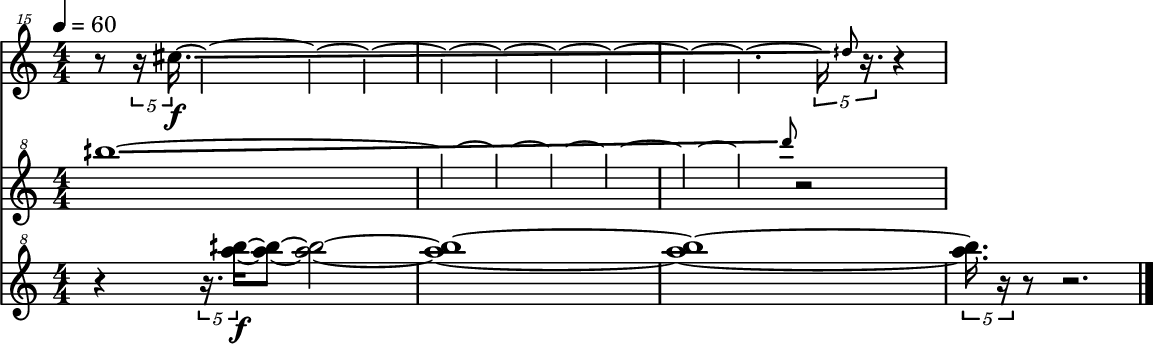

In [11]:
sco.show()